In [33]:
imgPath = "https://tech.fusic.co.jp/wp-content/uploads/2018/10/fusic_logo_1600-1.png"

https://tech.fusic.co.jp/wp-content/uploads/2018/10/fusic_logo_1600-1.png

In [41]:
(*
  EdgeDetectでエッジを抽出
  エッジの位置を取得
  EdgeDetectでエッジの画像データを作成
*)
edgePosition[path_] := {#2, -#1} & @@@ Position[ImageData[EdgeDetect[Import[imgPath]]], 1, {2}]

In [43]:
edgePos = edgePosition[imgPath]

{{797, -1}, {802, -1}, {796, -2}, {799, -2}, {800, -2}, {803, -2}, {795, -3}, {804, -3}, {794, -4}, {805, -4}, {793, -5}, {806, -5}, {792, -6}, {807, -6}, {791, -7}, {808, -7}, {790, -8}, {809, -8}, {789, -9}, {810, -9}, {788, -10}, {791, -10}, {811, -10}, {787, -11}, {790, -11}, {812, -11}, {786, -12}, {789, -12}, {813, -12}, {785, -13}, {788, -13}, {814, -13}, {784, -14}, {787, -14}, {815, -14}, {783, -15}, {786, -15}, {816, -15}, {782, -16}, {785, -16}, {817, -16}, {781, -17}, {784, -17}, {818, -17}, {780, -18}, {819, -18}, {779, -19}, {780, -19}, {820, -19}, {778, -20}, {779, -20}, {821, -20}, {777, -21}, {778, -21}, {822, -21}, {776, -22}, {823, -22}, {775, -23}, {824, -23}, {774, -24}, {825, -24}, {773, -25}, {826, -25}, {772, -26}, {827, -26}, {771, -27}, {828, -27}, {770, -28}, {829, -28}, {769, -29}, {830, -29}, {768, -30}, {831, -30}, {767, -31}, {770, -31}, {832, -31}, {766, -32}, {769, -32}, {833, -32}, {765, -33}, {768, -33}, {834, -33}, {764, -34}, {767, -34}, {835, -34}, {763, -35}, {766, -35}, {836, -35}, {762, -36}, {765, -36}, {837, -36}, {761, -37}, {764, -37}, {838, -37}, {760, -38}, {761, -38}, {763, -38}, {839, -38}, {760, -39}, {840, -39}, {759, -40}, {841, -40}, {757, -41}, {758, -41}, {759, -41}, {842, -41}, {756, -42}, {757, -42}, {843, -42}, {755, -43}, {844, -43}, {754, -44}, {845, -44}, {753, -45}, {846, -45}, {752, -46}, {847, -46}, {751, -47}, {848, -47}, {750, -48}, {849, -48}, {749, -49}, {752, -49}, {850, -49}, {748, -50}, {751, -50}, {851, -50}, {747, -51}, {750, -51}, {852, -51}, {746, -52}, {749, -52}, {853, -52}, {745, -53}, {748, -53}, {854, -53}, {744, -54}, {747, -54}, {855, -54}, {743, -55}, {746, -55}, {856, -55}, {742, -56}, {745, -56}, {857, -56}, {741, -57}, {744, -57}, {858, -57}, {740, -58}, {741, -58}, {743, -58}, {798, -58}, {799, -58}, {800, -58}, {801, -58}, {859, -58}, {740, -59}, {797, -59}, {798, -59}, {801, -59}, {802, -59}, {860, -59}, {739, -60}, {796, -60}, {797, -60}, {802, -60}, {803, -60}, {861, -60}, {738, -61}, {739, -61}, {795, -61}, {796, -61}, {803, -61}, {804, -61}, {862, -61}, {736, -62}, {737, -62}, {794, -62}, {795, -62}, {804, -62}, {805, -62}, {863, -62}, {735, -63}, {736, -63}, {793, -63}, {794, -63}, {805, -63}, {806, -63}, {864, -63}, {734, -64}, {792, -64}, {793, -64}, {806, -64}, {807, -64}, {865, -64}, {733, -65}, {791, -65}, {792, -65}, {807, -65}, {808, -65}, {866, -65}, {732, -66}, {790, -66}, {791, -66}, {808, -66}, {809, -66}, {867, -66}, {731, -67}, {734, -67}, {789, -67}, {790, -67}, {809, -67}, {810, -67}, {868, -67}, {730, -68}, {733, -68}, {788, -68}, {789, -68}, {810, -68}, {811, -68}, {869, -68}, {729, -69}, {732, -69}, {787, -69}, {788, -69}, {811, -69}, {812, -69}, {870, -69}, {728, -70}, {731, -70}, {786, -70}, {787, -70}, {812, -70}, {813, -70}, {871, -70}, {727, -71}, {730, -71}, {785, -71}, {786, -71}, {813, -71}, {814, -71}, {872, -71}, {726, -72}, {729, -72}, {784, -72}, {785, -72}, {814, -72}, {815, -72}, {873, -72}, {725, -73}, {728, -73}, {783, -73}, {784, -73}, {815, -73}, {816, -73}, {874, -73}, {724, -74}, {727, -74}, {782, -74}, {783, -74}, {816, -74}, {817, -74}, {875, -74}, {723, -75}, {726, -75}, {781, -75}, {782, -75}, {817, -75}, {818, -75}, {876, -75}, {722, -76}, {725, -76}, {780, -76}, {781, -76}, {818, -76}, {819, -76}, {877, -76}, {721, -77}, {724, -77}, {779, -77}, {780, -77}, {819, -77}, {820, -77}, {878, -77}, {720, -78}, {723, -78}, {778, -78}, {779, -78}, {820, -78}, {821, -78}, {879, -78}, {719, -79}, {720, -79}, {722, -79}, {777, -79}, {778, -79}, {821, -79}, {822, -79}, {880, -79}, {719, -80}, {776, -80}, {777, -80}, {822, -80}, {823, -80}, {881, -80}, {718, -81}, {775, -81}, {776, -81}, {823, -81}, {824, -81}, {882, -81}, {716, -82}, {717, -82}, {774, -82}, {775, -82}, {824, -82}, {825, -82}, {883, -82}, {715, -83}, {716, -83}, {773, -83}, {774, -83}, {825, -83}, {826, -83}, {884, -83}, {714, -84}, {772, -84}, {773, -84}, {826, -84}, {827, -84}, {885, -84}, {713, -85}, {771, -85}, {772, -85}, {827, -85},

In [44]:
(*
  エッジ点からランダムカーブを取得
*)
pointListToLines[pointList_, neighbothoodSize_: 6] :=
  Module[
    {
      (* 重複を削除したものをLへ代入 *)
      L = DeleteDuplicates[pointList],
      NF,
      lambda,
      lineBag,
      counter,
      seenQ,
      sLB,
      nearest,
      nearest1,
      nextPoint,
      couldReverseQ,
      d, n, s
    },
    (* Lに対するnearist関数を定義 *)
    NF = Nearest[L];
    (* 重複無しの長さを取得 *)
    lambda = Length[L];
    Monitor[
      (* データをここに格納 *)
      lineBag = {};
      counter = 0;
      While[counter < lambda,
        (* 未選択のランダムな一点を選択 *)
        sLB = {RandomChoice[DeleteCases[L, _?seenQ]]};
        (* 選択された部分はフラグを立てる *)
        seenQ[sLB[[1]]] = True;
        counter++;
        couldReverseQ = True;
        (* データの生成 *)
        While[
          (
            (* neighbothoodSizeを中心とする点群の集合を作成 *)
            nearest = NF[Last[sLB], {Infinity, neighbothoodSize}];
            (* ユークリッド距離でソート *)
            nearest1 = SortBy[DeleteCases[nearest, _?seenQ], 1. EuclideanDistance[Last[sLB], #] &];
            nearest1 =!= {} || couldReverseQ
          ),
          If[nearest1 === {},
            (* 全ての点を網羅したとき終了 *)
            sLB = Reverse[sLB];
            couldReverseQ = False,
            (* まだ残っているのであれば、次点を作成 *)
            nextPoint = If[Length[sLB] <= 3,
                (* sLBの中身が3以下であれば、一番中心と近い点を抽出 *)
                nearest1[[1]],
                (* 3つ以上あるならば、急カーブとならないよう抽出点を調整 *)
                d = 1. Normalize[(sLB[[-1]] - sLB[[-2]]) + 1/2 (sLB[[-2]] - sLB[[-3]])];
                n = {-1, 1} Reverse[d];
                s = Sort[{Sqrt[(d.(# - sLB[[-1]]))^2 + 2 (n. (# - sLB[[-1]]))^2], #} & /@ nearest1];
                s[[1, 2]]
            ];
            AppendTo[sLB, nextPoint];
            seenQ[nextPoint] = True;
            counter++
          ]
        ];
        AppendTo[lineBag, sLB]
      ];
      (* 線の長さでソートしたものを返す *)
      Reverse[SortBy[Select[lineBag, Length[#] > 12 &], Length]],
      (*monitor progress
      Grid[
        {
          {
            Text[
              Style["progress point joining", Darker[Green, 0.66]]
            ],
            ProgressIndicator[counter/lambda]
          },
          {
            Text[Style["number of segments",
            Darker[Green, 0.66]]],
            Length[lineBag] + 1
          }
        },
        Alignment -> Left, Dividers -> Center
      ]
      *)
    ]
  ]

In [46]:
hlines = pointListToLines[edgePos];


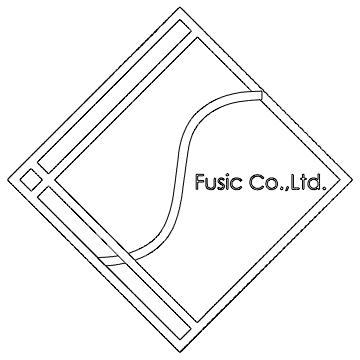

In [47]:
Graphics[Line[#] & /@ hlines]

Out[324]:
 
 
 
 
 Out[326]:
 
 
 
 
 Out[327]:
 
 
 
 
 Out[328]:
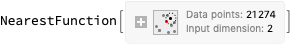

In [323]:
(* Lに対するnearist関数を定義 *)
NF = Nearest[L]
(* 重複無しの長さを取得 *)
lambda = Length[L]
lineBag = {}
counter = 0

Out[292]:
 
 
 
 
 Out[293]:
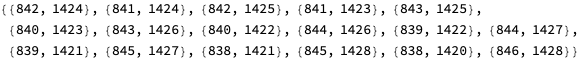

In [289]:
(* neighbothoodSizeを中心とする点群の集合を作成 *)
nearest = NF[Last[sLB], {Infinity, neighbothoodSize}];
(* ユークリッド距離でソート *)
nearest1 = SortBy[DeleteCases[nearest, _?seenQ], 1. EuclideanDistance[Last[sLB], #] &]
nearest1 =!= {} || couldReverseQ

In [329]:
sLB = {RandomChoice[DeleteCases[L, _?seenQ]]}
(* 選択された部分はフラグを立てる *)
seenQ[sLB[[1]]] = True
counter++
couldReverseQ = True

Set::write: Tag List in {}[{738, 989}] is Protected.
 
 
 Out[329]:
 
 
 
 
 Out[331]:
 
 
 
 
 Out[332]:
 
 
 
 
 Out[333]:

Out[340]:
 
 
 
 
 Out[342]:
 
 
 
 
 Out[343]:
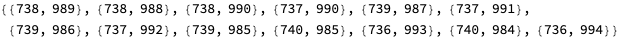
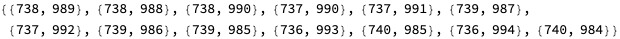

In [339]:
(* neighbothoodSizeを中心とする点群の集合を作成 *)
nearest = NF[Last[sLB], {Infinity, neighbothoodSize}]
(* ユークリッド距離でソート *)
nearest1 = SortBy[DeleteCases[nearest, _?seenQ], 1. EuclideanDistance[Last[sLB], #] &]
nearest1 =!= {} || couldReverseQ

In [344]:
Length[sLB] 

1

In [93]:
L = DeleteDuplicates[pointList];

In [227]:
sLB = {RandomChoice[DeleteCases[L, _?seenQ]]}

{{707, 1509}}